# ETH Price Prediction

Time searis of ETH Price

## 1. EDA

In [1]:
from pandas import read_csv
from pandas import datetime
from pandas import Series
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
import time
import pandas as pd
import numpy as np
#import plotly

# set random seed
np.random.seed(1337)

In [2]:
# load dataset
dates = pd.date_range('2016-01-01', '2017-09-17')
series = pd.DataFrame(index=dates)
series_temp = read_csv('cryptocurrencypricehistory/ethereum_price.csv', index_col="Date", parse_dates=True,
                             usecols=['Date', 'Close'], na_values=['nan'])
series_temp = series_temp.rename(columns={'Close': 'ETH'})
series = series.join(series_temp).squeeze()

In [3]:
print series.shape

(626,)


In [4]:
# summarize first few rows
print(series.tail())

2017-09-13    277.11
2017-09-14    213.91
2017-09-15    250.46
2017-09-16    246.52
2017-09-17    251.75
Freq: D, Name: ETH, dtype: float64


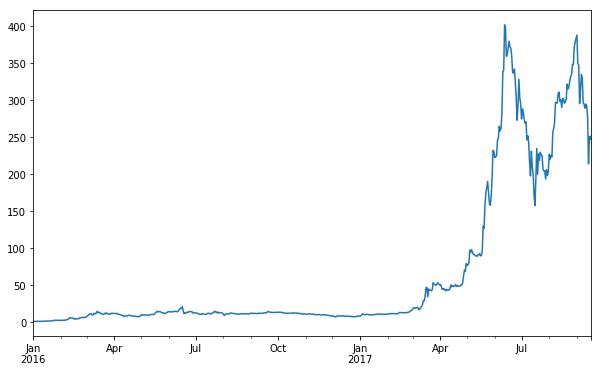

In [5]:
# line plot
pyplot.figure(figsize=(10,6))
series.plot()
pyplot.show()

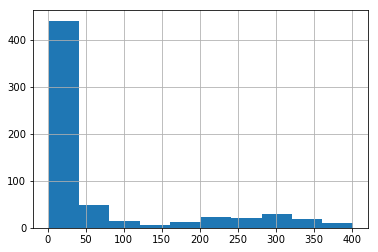

In [23]:
count, division = np.histogram(series)
series.hist(bins=division)
pyplot.show()

## 2. Check Stationarity

#### ACF and PACF

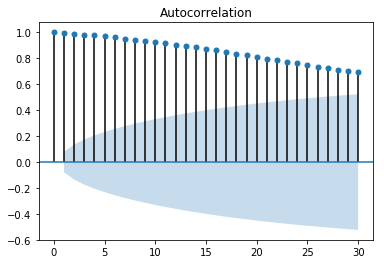

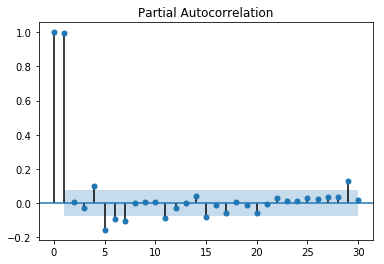

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(series, lags=30)
plot_pacf(series, lags=30)
pyplot.show()

#### ADF Test

In [25]:
from statsmodels.tsa.stattools import adfuller

X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.535424
p-value: 0.515920


We cannot reject the null hypothesis that the series is stationary

## 3. Data Transformation

Need to transform the non-stationary series into staionary one

In [5]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)


# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

Scale the data

In [6]:
from sklearn.preprocessing import MinMaxScaler

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
    
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X[0]] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

Frame the time series as a supervised learning problem

In [7]:
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [8]:
diff_values = difference(series.values, 1)
print diff_values.shape

(625,)


In [9]:
supervised = timeseries_to_supervised(diff_values, 1)
print(supervised.tail())

         0      0
620  -3.07 -14.35
621 -14.35 -63.20
622 -63.20  36.55
623  36.55  -3.94
624  -3.94   5.23


In [10]:
# split data into train and test-sets
supervised_values = supervised.values
train, test = supervised_values[:620], supervised_values[620:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

Verify the shapes

In [11]:
print 'raw data:', supervised_values.shape
print 'train:', train_scaled.shape
print 'test:', test_scaled.shape

raw data: (625, 2)
train: (620, 2)
test: (5, 2)


## 4. LSTM Modeling

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import TensorBoard
from math import sqrt

Using TensorFlow backend.


### 4.1 Baseline Model

In [13]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [ ]:
start_time = time.time()
lstm_model = fit_lstm(train_scaled, 1, 100, 4)
print "Done. Time used: ", (time.time() - start_time)

In [28]:
lstm_model.save('model/eth.h5')

### 4.2 Baseline Model with 3k Epochs

In [ ]:
start_time = time.time()
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
print "Done. Time used: ", (time.time() - start_time)

In [28]:
lstm_model.save('model/eth_3k.h5')

### 4.3 Model with Window Size of 7 with 3k Epochs

Use data with lag (window size) of 7

In [15]:
supervised_lag7 = timeseries_to_supervised(diff_values, 7)
print(supervised_lag7.tail())

         0      0      0      0      0      0      0      0
620  -3.07   5.78  -5.65  -2.10 -32.93  -4.91  21.35 -14.35
621 -14.35  -3.07   5.78  -5.65  -2.10 -32.93  -4.91 -63.20
622 -63.20 -14.35  -3.07   5.78  -5.65  -2.10 -32.93  36.55
623  36.55 -63.20 -14.35  -3.07   5.78  -5.65  -2.10  -3.94
624  -3.94  36.55 -63.20 -14.35  -3.07   5.78  -5.65   5.23


In [16]:
# split data into train and test-sets
supervised_values = supervised_lag7.values
train_7, test_7 = supervised_values[:620], supervised_values[620:]

# transform the scale of the data
scaler_7, train_scaled_7, test_scaled_7 = scale(train_7, test_7)

In [17]:
print 'train:', train_scaled_7.shape
print 'test:', test_scaled_7.shape

train: (620, 8)
test: (5, 8)


Training

In [18]:
start_time = time.time()
lstm_model = fit_lstm(train_scaled_7, 1, 3000, 4)
print "Done. Time used: ", (time.time() - start_time)

Done. Time used:  7667.05636787


In [20]:
lstm_model.save('model/eth_7_3k.h5')

## 5. Testing

In [14]:
from keras.models import load_model
from sklearn.metrics import mean_squared_error


# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(X.shape[0], 1, X.shape[1])
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]


# make prediction and plot the results
def evaluation(lstm_model, raw_values, scaled_data, expected_values, scaler, batch_size=1):
    # forecast the entire training dataset to build up state for forecasting
    train = scaled_data[:, 0:-1]
    train_reshaped = train.reshape(train.shape[0], 1, train.shape[1])
    lstm_model.predict(train_reshaped, batch_size=batch_size)

    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(scaled_data) - batch_size + 1):
        # make one-step forecast
        X, y = scaled_data[i:i+batch_size, 0:-1], scaled_data[i:i+batch_size, -1]
        yhat = forecast_lstm(lstm_model, batch_size, X)

        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(scaled_data)+1-i)

        # store forecast
        predictions.append(yhat)

    # report performance
    rmse = sqrt(mean_squared_error(expected_values, predictions))
    print('Test RMSE: %.3f' % rmse)

    # line plot of observed vs predicted
    pyplot.figure(figsize=(10,6))
    pyplot.plot(expected_values, label="expected")
    pyplot.plot(predictions, label="prediction")
    pyplot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    pyplot.show()

### 5.1 Baseline Model

Check the model against training data

In [15]:
lstm_model = load_model('model/eth.h5')

Test RMSE: 9.461


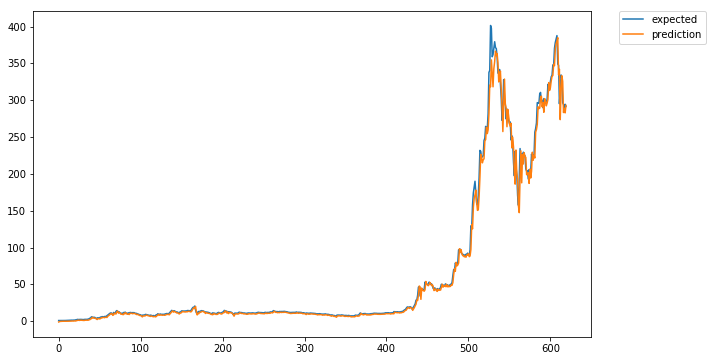

In [16]:
evaluation(lstm_model, series.values[:len(train_scaled)+1], train_scaled, series.values[1:621], scaler)

Evaluate against test data

Test RMSE: 37.313


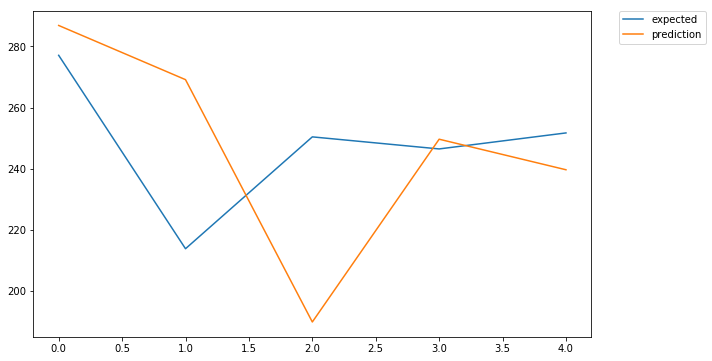

In [17]:
evaluation(lstm_model, series.values, test_scaled, series.values[-len(test_scaled):], scaler)

### 5.2 Baseline Model with 3k Epoches

Check the model against training data

In [48]:
lstm_model = load_model('model/eth_3k.h5')

Test RMSE: 8.195


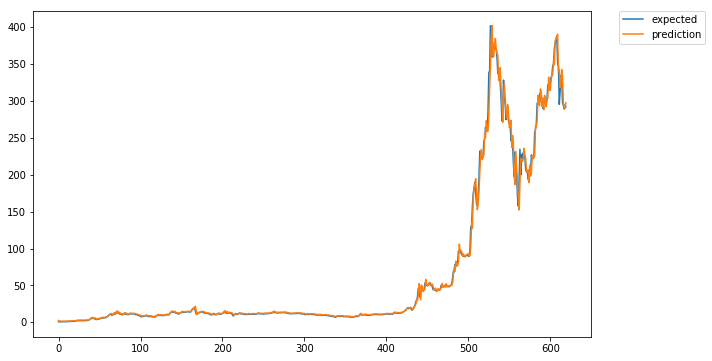

In [29]:
evaluation(lstm_model, series.values[:len(train_scaled)+1], train_scaled, series.values[1:621], scaler)

Evaluate against test data

Test RMSE: 30.681


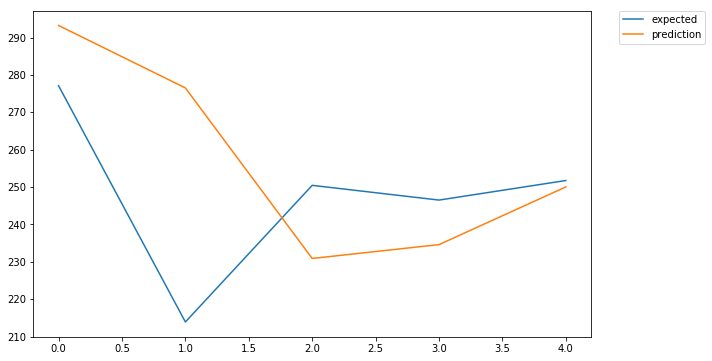

In [30]:
evaluation(lstm_model, series.values, test_scaled, series.values[-len(test_scaled):], scaler)

### 5.3 Model with Window Size of 7

In [43]:
lstm_model = load_model('model/eth_7_3k.h5')

Check the model against training data

Test RMSE: 4.464


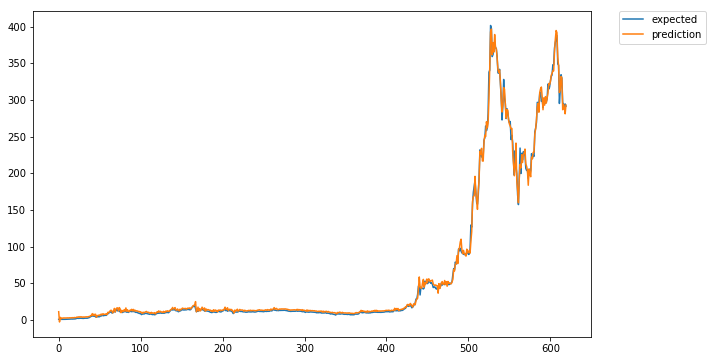

In [23]:
evaluation(lstm_model, series.values[:len(train_scaled_7)+1], train_scaled_7, series.values[1:621], scaler_7)

Evaluate against test data

Test RMSE: 33.949


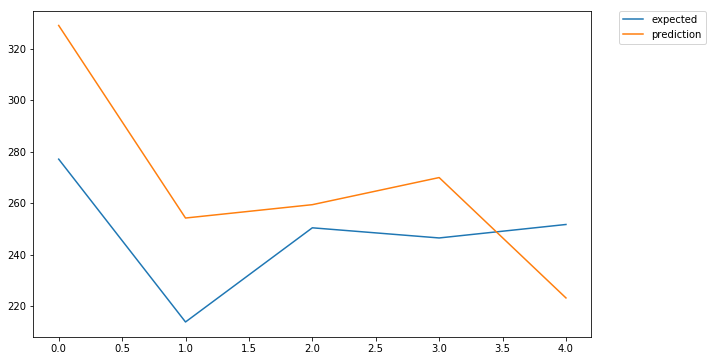

In [24]:
evaluation(lstm_model, series.values, test_scaled_7, series.values[-len(test_scaled_7):], scaler_7)